In [8]:
import sys
import os

# Add the project root to sys.path
sys.path.append("/Users/goodmanwu/Desktop/stat413model/stat413-boxoffice")
import sys
print(sys.path)

['/Users/goodmanwu/Desktop/stat413model/stat413-boxoffice/boxoffice/modeling', '/Users/goodmanwu/.vscode/extensions/ms-toolsai.jupyter-2022.4.1021342353/pythonFiles', '/Users/goodmanwu/.vscode/extensions/ms-toolsai.jupyter-2022.4.1021342353/pythonFiles/lib/python', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/goodmanwu/Desktop/stat413model/stat413-boxoffice/venv/lib/python3.12/site-packages', '/Users/goodmanwu/Desktop/stat413model/stat413-boxoffice']


In [9]:
# imports
from boxoffice.modeling.cleaned_data import X_train, y_train, X_test, y_test
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf

MOVIES_DB_PATH: boxoffice/db/data/data.sqlite
MOVIES_DB_PATH: ../boxoffice/db/data/data.sqlite
movies.csv exists, 1732658019.9106991, 1732655031.5551286
Reading from movies.csv
Index([], dtype='object')


In [10]:
X_train['opening_wide_revenue'] = y_train
X_test['opening_wide_revenue'] = y_test
X_train['production_method'] = X_train['production_method'].replace('Stop-Motion Animation', 'Digital Animation')
X_test['production_method'] = X_test['production_method'].replace('Stop-Motion Animation', 'Digital Animation')

/var/folders/pp/mkrvmf_d5p7d78r3bqvkxswr0000gn/T/ipykernel_50226/3335510034.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['opening_wide_revenue'] = y_test


In [11]:
formula1 = "opening_wide_revenue ~ 0 + top_5_trailer_views + budget + wikipedia_pre_release_cumulative_views + wikipedia_pre_release_cumulative_views : in_franchise : production_method"
formula2 = "opening_wide_revenue ~ 0 + budget + wikipedia_pre_release_cumulative_views + wikipedia_pre_release_cumulative_views : in_franchise : production_method"
formula3 = "opening_wide_revenue ~ 0 + budget + wikipedia_pre_release_monday_views + wikipedia_pre_release_monday_views : in_franchise : production_method"

formula = formula2

model_simple_glm = smf.glm(formula=formula, data=X_train).fit()

pred_simple_glm = model_simple_glm.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, pred_simple_glm))
print(model_simple_glm.summary())

train_pred = model_simple_glm.predict(X_train)

training_data = pd.DataFrame(
    {
        "actual": y_train,
        "predicted": train_pred,
        "title": X_train["title"],
        "production_method": X_train["production_method"],
    }
)

# write to a file
training_data.to_csv("training_data.csv")

fig = px.scatter(training_data, x="actual", y="predicted", hover_name="title", color="production_method")
fig.add_trace(go.Scatter(x=training_data["actual"], y=training_data["actual"], mode="lines", name="y=x"))
fig.update_layout(title="Actual vs Predicted Opening Weekend Revenue", xaxis_title="Actual", yaxis_title="Predicted")

RMSE: 22323753.63116176
                  Generalized Linear Model Regression Results                   
Dep. Variable:     opening_wide_revenue   No. Observations:                  677
Model:                              GLM   Df Residuals:                      672
Model Family:                  Gaussian   Df Model:                            4
Link Function:                 Identity   Scale:                      3.6368e+14
Method:                            IRLS   Log-Likelihood:                -12307.
Date:                  Tue, 26 Nov 2024   Deviance:                   2.4439e+17
Time:                          16:55:02   Pearson chi2:                 2.44e+17
No. Iterations:                       3   Pseudo R-squ. (CS):             0.9577
Covariance Type:              nonrobust                                         
                                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
-----

In [12]:
results_df = pd.DataFrame({'title': X_test['title'], 'actual': y_test, 'predicted': pred_simple_glm, 'production_method': X_test['production_method']})

# plot actual vs predicted
fig = px.scatter(results_df, x='actual', y='predicted', hover_name='title', color='production_method')
fig.add_trace(go.Scatter(x=results_df['actual'], y=results_df['actual'], mode='lines', name='y=x'))
fig.update_layout(title='Actual vs Predicted Opening Weekend Revenue', xaxis_title='Actual', yaxis_title='Predicted')

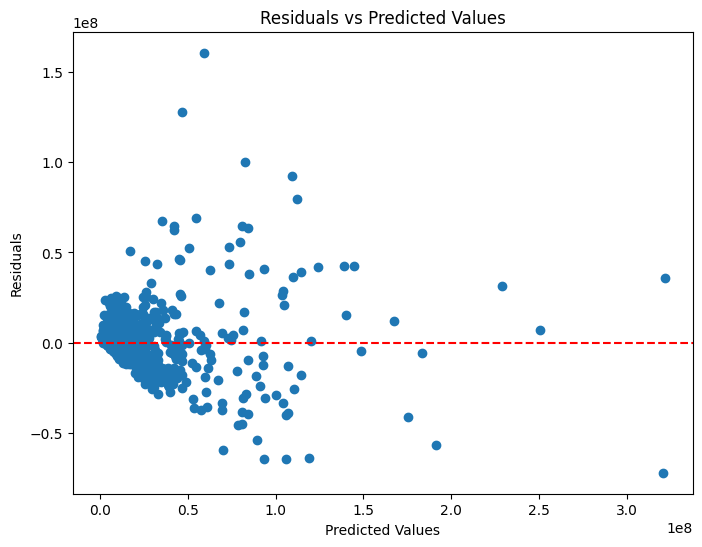

In [13]:
import matplotlib.pyplot as plt
training_data["residuals"] = training_data["actual"] - training_data["predicted"]

# Residuals Plot
plt.figure(figsize=(8, 6))
plt.scatter(training_data["predicted"], training_data["residuals"])
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

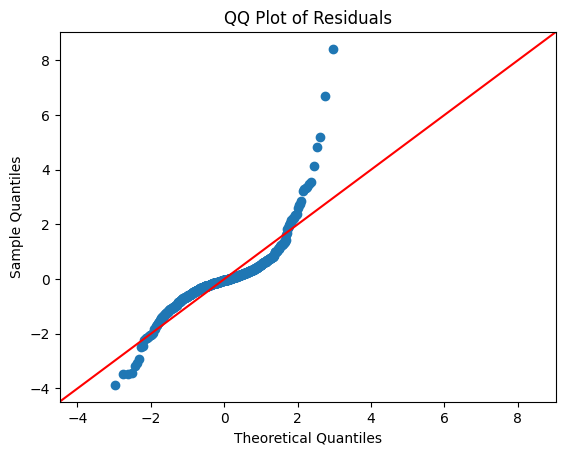

In [ ]:
import statsmodels.api as sm
sm.qqplot(training_data["residuals"], line="45", fit=True)
plt.title("QQ Plot of Residuals")
plt.show()

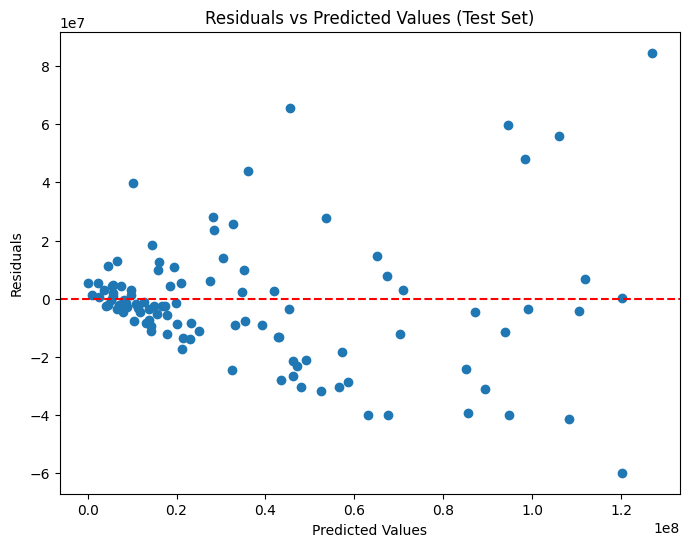

In [ ]:
results_df["residuals"] = results_df["actual"] - results_df["predicted"]

plt.figure(figsize=(8, 6))
plt.scatter(results_df["predicted"], results_df["residuals"])
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values (Test Set)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

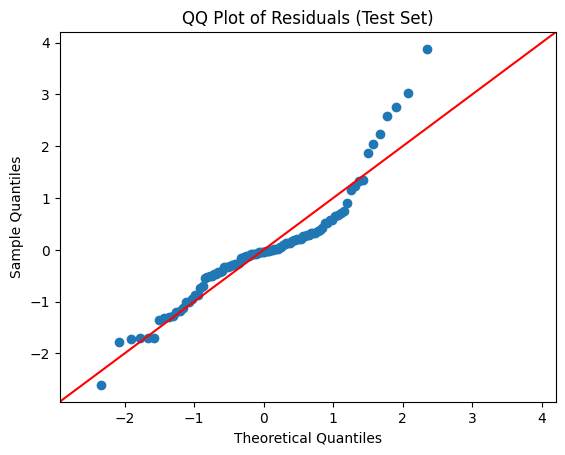

In [ ]:
sm.qqplot(results_df["residuals"], line="45", fit=True)
plt.title("QQ Plot of Residuals (Test Set)")
plt.show()

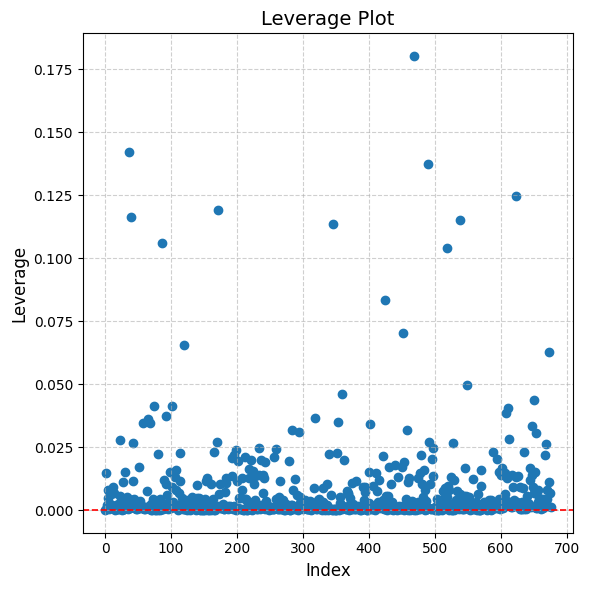

In [ ]:
influence = model_simple_glm.get_influence()
leverage = influence.hat_matrix_diag  # Leverage values

# Create the plot
plt.figure(figsize=(6, 6))
plt.scatter(range(len(leverage)), leverage)
plt.axhline(y=0, color="red", linestyle="--", linewidth=1.2)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Leverage", fontsize=12)
plt.title("Leverage Plot", fontsize=14)
plt.grid(linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
coefficients = model_simple_glm.params
coefficients[0]

/var/folders/sl/2bth227n2bz24mmk9w3byqth0000gn/T/ipykernel_4014/2050972200.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



np.float64(0.17200364368552845)

/var/folders/sl/2bth227n2bz24mmk9w3byqth0000gn/T/ipykernel_4014/363825280.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



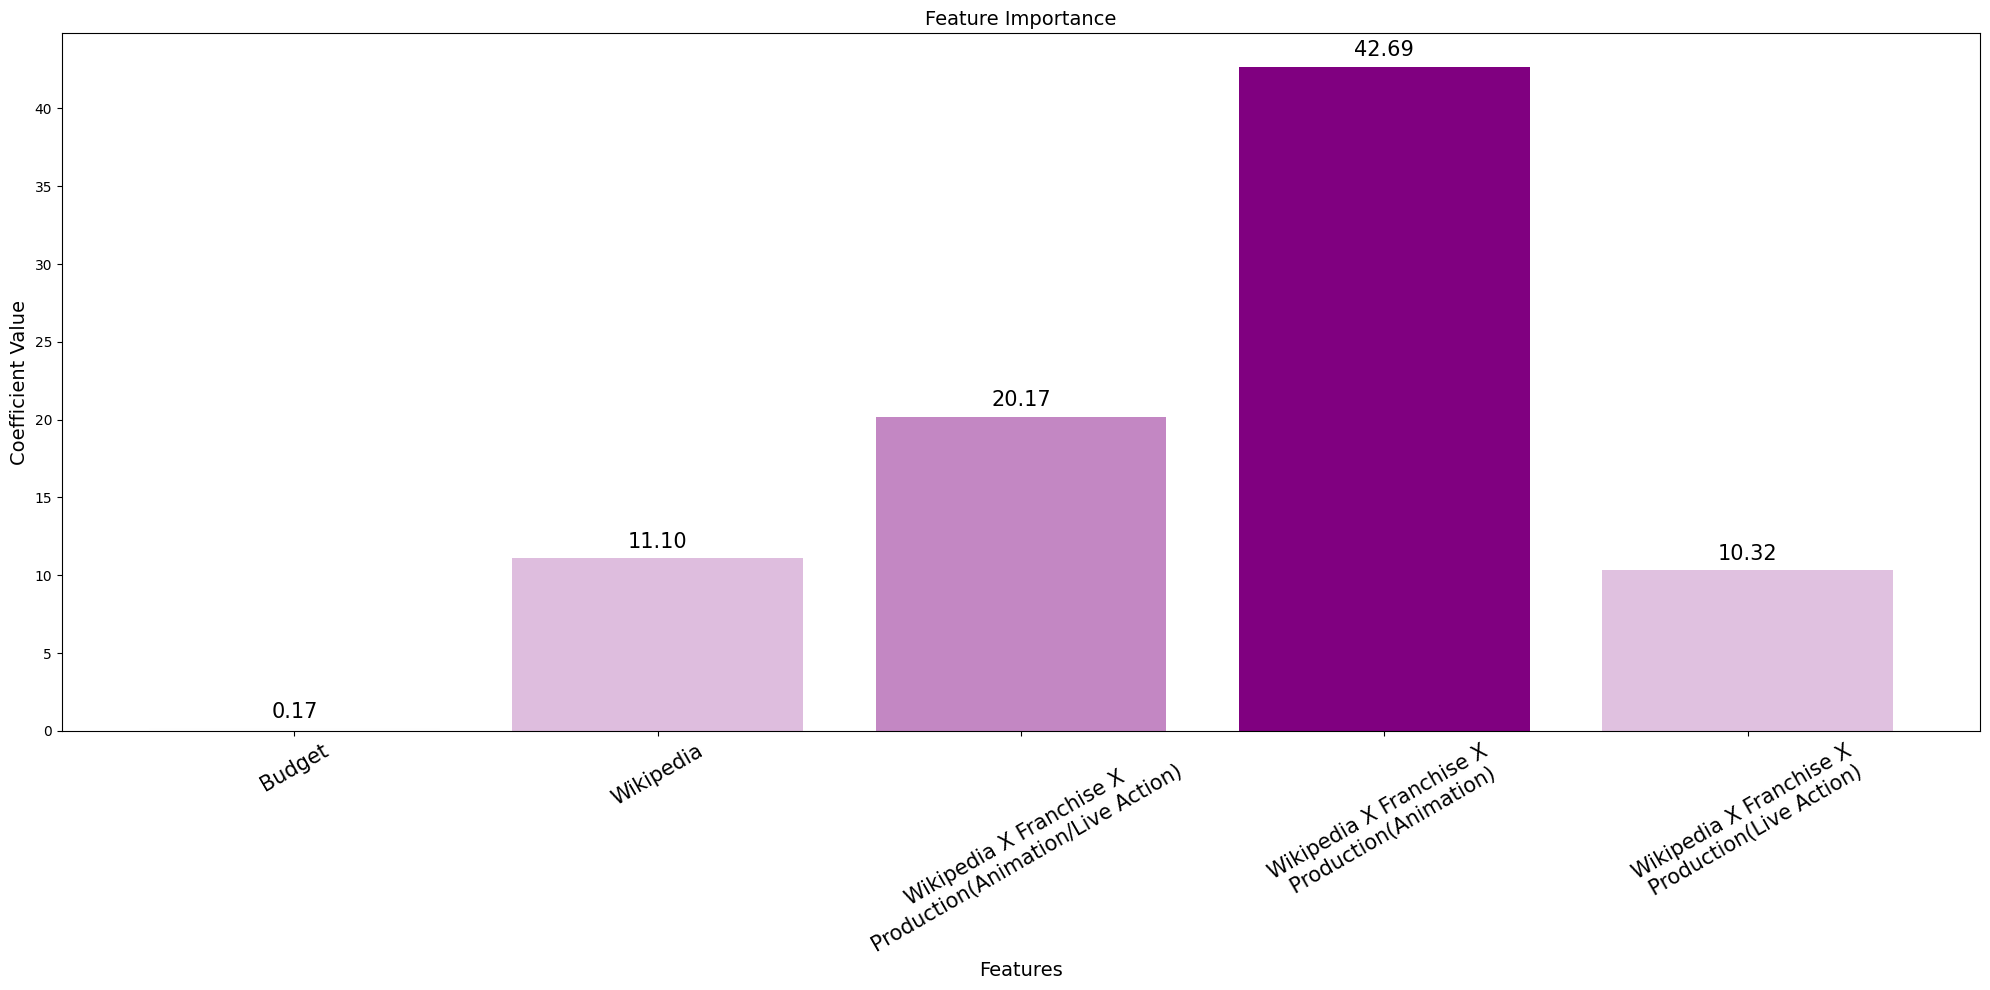

In [ ]:
#feature_names = X_train.drop(columns=["title", "production_method"]).columns
feature_names = coefficients.index
coefficients = model_simple_glm.params
feature_names = ["Budget", "Wikipedia", "Wikipedia X Franchise X\nProduction(Animation/Live Action)", "Wikipedia X Franchise X\n Production(Animation)", "Wikipedia X Franchise X\n Production(Live Action)"]

# Normalize coefficients for transparency
max_coef = max(coefficients, key=abs)
normalized_alpha = [abs(coef) / abs(max_coef) for coef in coefficients]

# Create the plot
fig, axs = plt.subplots(figsize=(20, 10))
for n, feature in enumerate(feature_names):
    coef = coefficients[n]
    axs.bar(
        feature,
        coef,
        color="Purple" if coef > 0 else "Red",
        alpha=normalized_alpha[n],
    )
    axs.text(
            n, coef + 0.01 * max_coef, f"{coef:.2f}", ha="center", va="bottom", fontsize=15
        )

axs.set_xticks(range(len(feature_names)))
axs.set_xticklabels(feature_names, rotation=30, ha = "center", fontsize = 15)
axs.set_title("Feature Importance", fontsize=14)
axs.set_ylabel("Coefficient Value", fontsize=14)
axs.set_xlabel("Features", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:

# Assuming leverage and other relevant data are available
influence = model_simple_glm.get_influence()
leverage = influence.hat_matrix_diag  # Leverage values

# Creating a DataFrame for the plot
leverage_df = pd.DataFrame({
    'Index': range(len(leverage)),
    'Leverage': leverage,
    'Residuals': model_simple_glm.resid_pearson,  # Standardized residuals
    'Title': X_train['title'],  # Assuming titles are in X_train
    'Production Method': X_train['production_method'],  # Assuming production method is in X_train
})

# Create the Plotly scatter plot for leverage with color based on production method
fig = px.scatter(
    leverage_df,
    x="Index",
    y="Leverage",
    hover_name="Title",  # Show the movie title on hover
    hover_data=["Residuals", "Production Method"],
    color="Production Method",  # Color by production method
    title="Leverage Plot",
)

# Add a horizontal baseline with a standout color
fig.add_trace(
    go.Scatter(
        x=leverage_df["Index"],
        y=[0] * len(leverage_df),
        mode="lines",
        line=dict(color="orange", width=2),  # Standout line style
        name="Baseline"
    )
)

# Update layout
fig.update_layout(
    xaxis_title="Index",
    yaxis_title="Leverage",
    template="plotly_white"
)

fig.show()

  Dataset           MSE        R²
0   Train  3.609927e+14  0.761082
1    Test  4.983500e+14  0.674956


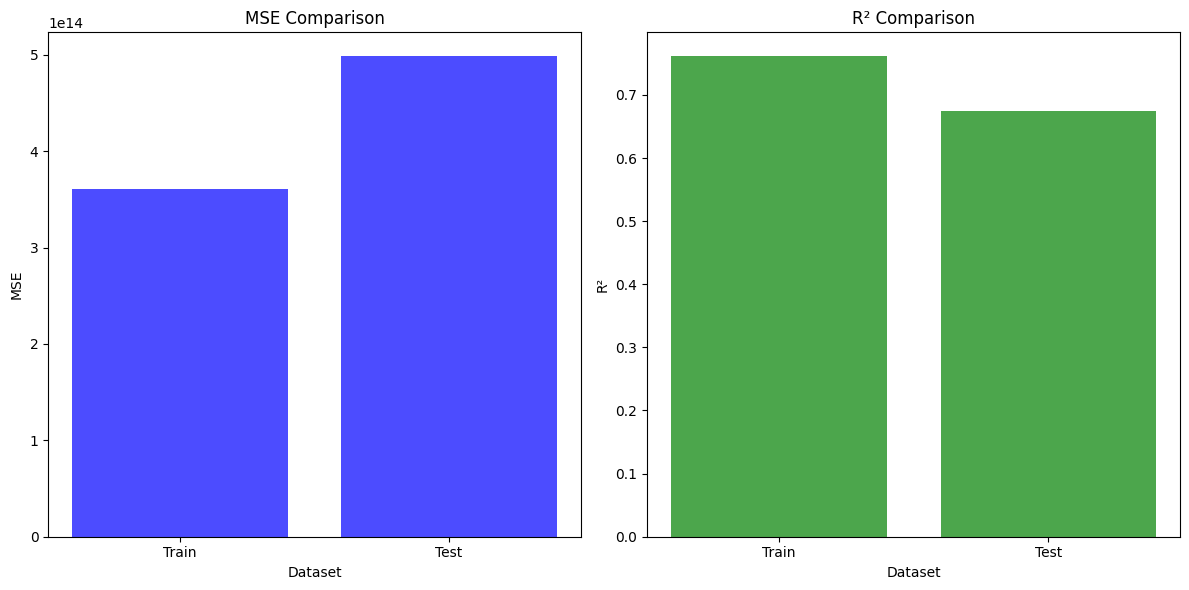

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R² and MSE for train and test datasets
mse_train = mean_squared_error(y_train, model_simple_glm.predict(X_train))
r2_train = r2_score(y_train, model_simple_glm.predict(X_train))

mse_test = mean_squared_error(y_test, pred_simple_glm)
r2_test = r2_score(y_test, pred_simple_glm)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MSE": [mse_train, mse_test],
    "R²": [r2_train, r2_test]
})

# Display the metrics table
print(metrics_df)



# Plot 2: Separate Plots for MSE and R² using Matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot MSE
ax[0].bar(metrics_df["Dataset"], metrics_df["MSE"], color="blue", alpha=0.7)
ax[0].set_title("MSE Comparison")
ax[0].set_ylabel("MSE")
ax[0].set_xlabel("Dataset")
ax[0].set_xticks(range(len(metrics_df)))
ax[0].set_xticklabels(metrics_df["Dataset"])

# Plot R²
ax[1].bar(metrics_df["Dataset"], metrics_df["R²"], color="green", alpha=0.7)
ax[1].set_title("R² Comparison")
ax[1].set_ylabel("R²")
ax[1].set_xlabel("Dataset")
ax[1].set_xticks(range(len(metrics_df)))
ax[1].set_xticklabels(metrics_df["Dataset"])

plt.tight_layout()
plt.show()

# Optional: Normalize metrics if scales differ too much
metrics_df["Normalized MSE"] = metrics_df["MSE"] / metrics_df["MSE"].max()
metrics_df["Normalized R²"] = metrics_df["R²"] / metrics_df["R²"].max()

# Plot Normalized Metrics for better comparison
normalized_metrics_melted = metrics_df.melt(
    id_vars= "Dataset",
    value_vars=["Normalized MSE", "Normalized R²"],
    var_name="Metric",
    value_name="Normalized Value"
)
fig = px.bar(
    normalized_metrics_melted,
    x="Dataset",
    y="Normalized Value",
    color="Metric",
    barmode="group",
    title="Comparison of Normalized R² and MSE for Train and Test Datasets",
    labels={"Normalized Value": "Normalized Metric Value"}
)
fig.show()

